# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [ ]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms
from torchvision.datasets import CIFAR10
import torch.utils.data as data

from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from tqdm import tqdm
import random

In [ ]:
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 1.12.1+cu113


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
# Constants
DATA_MEANS = [0.5, 0.5, 0.5]
DATA_STD = [0.5, 0.5, 0.5]
DATASET_PATH = "../data"
BATCH_SIZE = 64
# number of epochs
N_EPOCHS = 20

In [ ]:
# Transformations on the test set

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Transformations for the training
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Load the train set, with training transformations
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)

# Validation split
valid_size=0.2
train_length = len(train_dataset)
indices=list(range(len(train_dataset)))
split = int(np.floor(valid_size * train_length))
np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]

train_sampler=data.SubsetRandomSampler(train_idx)
validation_sampler=data.SubsetRandomSampler(valid_idx)


# Load the test set, with texst transformations
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# Train, Test, and Validation Data Loaders
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE,sampler=train_sampler)
val_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE,sampler=validation_sampler)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [ ]:
# Functio to show 5 images from the dataset
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()
        print(f" The size of the image is: {image.shape}")

cat


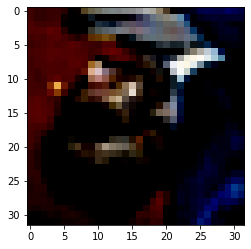

 The size of the image is: (3, 32, 32)
ship


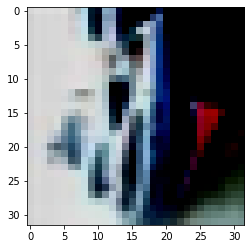

 The size of the image is: (3, 32, 32)
ship


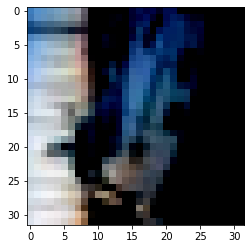

 The size of the image is: (3, 32, 32)
plane


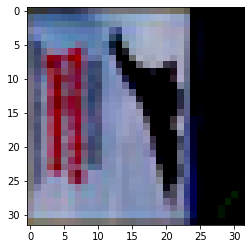

 The size of the image is: (3, 32, 32)
frog


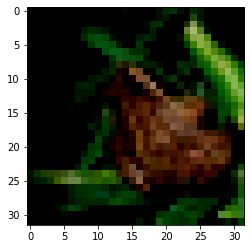

 The size of the image is: (3, 32, 32)


In [ ]:
# Explore data
## Show the images from the test datset  ##
show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, 
convolutional, or even something more advanced!

In [ ]:
## YOUR CODE HERE ##
# Model1: Using full conncted layers
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(3*32*32,2048)
        self.fc2=nn.Linear(2048,1024)
        self.fc3=nn.Linear(1024,512)
        self.fc4=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        self.dropout=nn.Dropout(0.25)

    def forward(self,x):
        x=x.view(-1,32*32*3)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.dropout(F.relu(self.fc3(x)))
        x=self.dropout(F.relu(self.fc4(x)))
        x=self.out(x)
        return x

In [ ]:
# Model2: Using convolution, batch normalisation , dropout layer
class convNet(nn.Module):
    def __init__(self):
        super(convNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv5=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.b1=nn.BatchNorm2d(16)
        self.b2=nn.BatchNorm2d(64)
        self.b3=nn.BatchNorm2d(256)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)  

        self.dropout=nn.Dropout(0.1)
        self.fc1=nn.Linear(256,128)
        self.fc2=nn.Linear(128,64)
        self.out=nn.Linear(64,10)


    def forward(self,x):
        x=self.pool(F.relu(self.b1(self.conv1(x))))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.b2(self.conv3(x))))
        x=self.pool(F.relu(self.conv4(x)))
        x=self.pool(F.relu(self.b3(self.conv5(x))))
        x=x.view(-1,256)
        x = self.dropout(x)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)   
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [ ]:
# Find the available device, if cuda available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Model's object instances
model_1=FNet()
model_2=convNet()

In [ ]:
# Transfer the model to the available device
model_1.to(device)
model_2.to(device)

convNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
## YOUR CODE HERE ##
# loss function: crossentropy
criterion=nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model_2.parameters(), lr=.01)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:
# List to store loss to visualize
train_losslist = []
valid_losslist = []
valid_loss_min = np.Inf

for epoch in range(N_EPOCHS):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model_2.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        data,target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_2(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model_2.eval()
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        data,target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_2(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    train_losslist.append(train_loss)
    valid_losslist.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_2.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 1.476592 	Validation Loss: 0.312558
Validation loss decreased (inf --> 0.312558).  Saving model ...
Epoch: 1 	Training Loss: 1.147132 	Validation Loss: 0.275002
Validation loss decreased (0.312558 --> 0.275002).  Saving model ...
Epoch: 2 	Training Loss: 1.007350 	Validation Loss: 0.237366
Validation loss decreased (0.275002 --> 0.237366).  Saving model ...
Epoch: 3 	Training Loss: 0.927792 	Validation Loss: 0.221663
Validation loss decreased (0.237366 --> 0.221663).  Saving model ...
Epoch: 4 	Training Loss: 0.861576 	Validation Loss: 0.215270
Validation loss decreased (0.221663 --> 0.215270).  Saving model ...
Epoch: 5 	Training Loss: 0.806381 	Validation Loss: 0.209755
Validation loss decreased (0.215270 --> 0.209755).  Saving model ...
Epoch: 6 	Training Loss: 0.771822 	Validation Loss: 0.189128
Validation loss decreased (0.209755 --> 0.189128).  Saving model ...
Epoch: 7 	Training Loss: 0.732776 	Validation Loss: 0.184072
Validation loss decreased (0.18912

Plot the training loss (and validation loss/accuracy, if recorded).

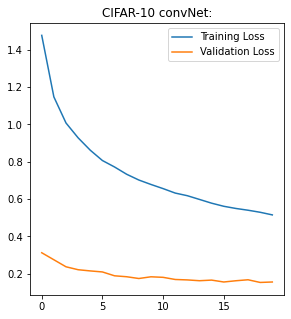

In [ ]:
# Plot the training and validation loss of convNet
fig = plt.figure(1,figsize=(10,5))
idx = 1
ax= fig.add_subplot(1,2,idx)
ax.plot(train_losslist,label="Training Loss")
ax.plot(valid_losslist,label="Validation Loss")
ax.set_title('CIFAR-10 convNet:')
plt.legend()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
# Test the model's performance on test dataset
total = 0
correct = 0
model_2.eval() # out our model in evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 75 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##
torch.save(model_2.state_dict(), 'model_cifar_convnet.pt')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.


**Solution:**
- Based on the above analysis, I will recommend to build an alogorithm in side the company instead of buying from outside.
- I got accuracy above 70% , using convolutional neural network.
- We can also increase the accuracy further, by using transfer learning, and some pretrained models like VGG19, RESNET.




In [ ]:
# References:
# - https://pytorch.org/tutorials/
# - https://github.com/NvsYashwanth/CIFAR-10-Image-Classification/blob/master/cifar10.ipynb
# - https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844
# - https://medium.com/analytics-vidhya/deep-learning-creating-an-image-classifier-using-pytorch-with-cifar-10-f603659722b2